# Calibration for Steering Angle

# Calibration Utilities
Needed by the functions in rampage_vehicle/rampage_conversions.h. Refer to that file for details.
This utilities deals with: 
* motorRpmToVelocity
* siToPwmVel
* pwmToSiVel
* phiToJrk
* siToPwmAng
* pwmToSiAng

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rosbag
import rospkg
from scipy import interpolate

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


In [2]:
bagfile = './2021-01-19-15-31-47_steering_calib.bag'
bag = rosbag.Bag(bagfile)
msg_info = bag.get_type_and_topic_info()
t0_rostime = bag.get_start_time()

In [3]:
# List the topics in the bag file
print(bag)

path:        /home/subhransu/projects/catkin_ws_ugv/src/rampage_missions/rosbag/2021-01-19-15-31-47_steering_calib.bag
version:     2.0
duration:    1:29s (89s)
start:       Jan 19 2021 15:31:47.48 (1611088307.48)
end:         Jan 19 2021 15:33:17.33 (1611088397.33)
size:        10.2 MB
messages:    41242
compression: none [13/13 chunks]
types:       nav_msgs/Odometry          [cd5e73d190d741a2f92e81eda573aca7]
             rampage_msgs/PwmCmds       [22ccb87ef1cf5602ef2c7fc2883f2809]
             rampage_msgs/UavCmds       [c03491c21306f475c85b11072e1bba31]
             rampage_msgs/WheelOdometry [20989e3454d9ae79dfde3b07d988a2c8]
             rosgraph_msgs/Log          [acffd30cd6b6de30f120938c17c593fb]
             sensor_msgs/Imu            [6a62c6daae103f4ff57a132d6f95cec2]
             sensor_msgs/MagneticField  [2f3b0b43eed0c9501de0fa3ff89a45aa]
             sensor_msgs/NavSatFix      [2d3a8cd499b9b4a0249fb98fd05cfa48]
             tf2_msgs/TFMessage         [94810edda583a504dfd

In [4]:
# read the odometry data
topic = '/odometry/filtered'
bagmsg = bag.read_messages(topics=topic)
message_count = msg_info.topics[topic].message_count
v_odometry = np.empty(message_count) # forward velocity
w_odometry = np.empty(message_count) # angular velocity
t_odometry = np.empty(message_count)

for i, msg in enumerate(bagmsg):
    if i is 0:
        t0_rostime = msg.message.header.stamp
    v_odometry[i] = msg.message.twist.twist.linear.x
    w_odometry[i] = msg.message.twist.twist.angular.z
    t_odometry[i] = (msg.message.header.stamp - t0_rostime).to_sec()
s_odometry = np.arctan(w_odometry*0.51/v_odometry)

In [5]:
# extract data in /pwm_cmds
topic = '/pwm_cmds'
bagmsg = bag.read_messages(topics=topic)
message_count = msg_info.topics[topic].message_count
v_pwm = np.empty(message_count) # velocity command in pwm units
s_pwm = np.empty(message_count) # steering command in pwm units
t_pwm = np.empty(message_count) 

for i, msg in enumerate(bagmsg):
    s_pwm[i] = msg.message.pwm_s
    v_pwm[i] = msg.message.pwm_v
    t_pwm[i] = (msg.message.t_epoch - t0_rostime).to_sec()

# interpolate the values to a common timestamp of odometry message
f = interpolate.interp1d(t_pwm, s_pwm, kind='linear', assume_sorted=True, fill_value="extrapolate")
s_pwm = f(t_odometry)
f = interpolate.interp1d(t_pwm, v_pwm, kind='linear', assume_sorted=True, fill_value="extrapolate")
v_pwm = f(t_odometry)    

In [6]:
# extract data from /wheel_odometry
topic = '/wheel_odometry'
bagmsg = bag.read_messages(topics=topic)
message_count = msg_info.topics[topic].message_count
t_wo = np.empty(message_count) 
sraw_wo = np.empty(message_count) 
for i, msg in enumerate(bagmsg):
    sraw_wo[i] = msg.message.servo_raw
    t_wo[i] = (msg.message.t_epoch - t0_rostime).to_sec()

    # interpolate the values to a common timestamp of odometry message
f = interpolate.interp1d(t_wo, sraw_wo, kind='linear', assume_sorted=True, fill_value="extrapolate")
sraw_wo = f(t_odometry)   

Text(0, 0.5, 'pwm')

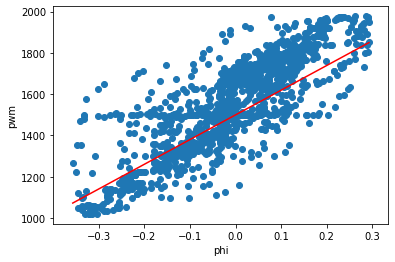

In [12]:
# extract steering angle using this formula w = v*tan(phi)/l for cases when velocity is >0.4m/sec
idx = np.where( (v_odometry>1.5) & (v_odometry<2.5) & (s_pwm>1020) & (s_pwm<1980))
phi = np.arctan(0.51*w_odometry/v_odometry)
plt.scatter(phi[idx], s_pwm[idx])
x_phi = np.array([np.min(phi[idx]), np.max(phi[idx])])
siToPwmAng = lambda x : 1195.8*x_phi + 1500
y_phi = siToPwmAng(x_phi)
plt.plot(x_phi,y_phi, 'r')
plt.xlabel('phi')
plt.ylabel('pwm')
# siToPwmAng = 

Text(0, 0.5, 'phi (radians)')

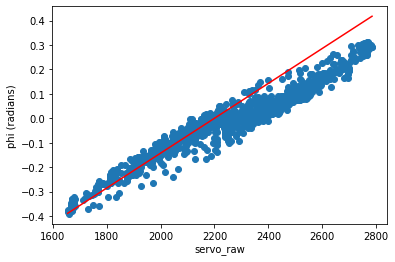

In [8]:
#servoToSiAng
plt.figure()
plt.scatter(sraw_wo[idx], phi[idx])
servoToSiAng = lambda x: (x - 2200) * 0.000714295499404
x = np.array([np.min(sraw_wo[idx]), np.max(sraw_wo[idx])])
y = servoToSiAng(x)
plt.plot(x, y, 'r')
plt.xlabel('servo_raw')
plt.ylabel('phi (radians)')

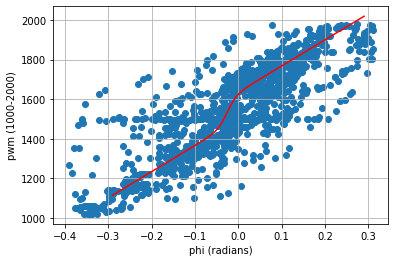

In [13]:
siToPwmVel = lambda vel_si: 1500+31.32516*vel_si
phiToJrk = lambda phi: 1434.4941*phi + 2275.5982 + 74.6464*np.tanh(46.4265*phi + 1.2077)
jrkToPwm = lambda jrk: 0.921*(jrk-1600) + 945
siToPwmAng = lambda si_ang: jrkToPwm(phiToJrk(si_ang))

# plt.scatter(phi[idx], s_pwm[idx])
phi_test = np.linspace(-0.29, 0.29, 100)
plt.plot(phi_test, siToPwmAng(phi_test), 'r')
plt.xlabel('phi (radians)')
plt.ylabel('pwm (1000-2000)')
plt.grid('on')
plt.scatter(phi[idx], s_pwm[idx])

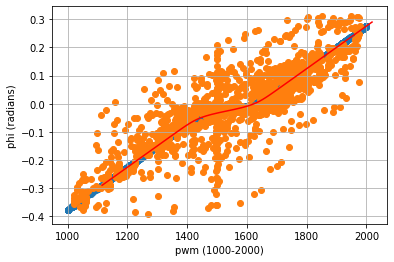

In [14]:
from pynverse import inversefunc
s_cmd = inversefunc(siToPwmAng, s_pwm)
plt.figure()
plt.plot(siToPwmAng(phi_test), phi_test, 'r')
plt.scatter(s_pwm, s_cmd)
plt.scatter(s_pwm[idx],phi[idx])
plt.xlabel('pwm (1000-2000)')
plt.ylabel('phi (radians)')
plt.grid('on')